# Overview of notebook

0. Preperation
1. Scraping Reddit
2. Processing data
3. Exploring data
4. Topic modelling
5. Sentiment analysis
6. Topic and sentiment combined

# 0. Preperation

First, we'll start by importing the necessary libraries.

Then, we'll enter Reddit account details in order to scrape the subreddits. In this notebook, the information regarding account details are removed. If you want to run this code yourself, get account details by creating a Reddit app here: https://www.reddit.com/prefs/apps.

In [1]:
#Importing the required libraries
#Scraping
import praw
from praw.models import MoreComments
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
from PIL import Image
import easyocr
import io
import pandas as pd
import os
import tqdm
#Exploring data
import matplotlib.pyplot as plt
import seaborn as sns
#topic modelling
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
#sentiment analysis
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from scipy.stats import f_oneway
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

#Set working directory
cwd = os.getcwd()

#Set style for plots
sns.set(style="whitegrid")


c:\Users\noort\.conda\envs\Thesis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\noort\.conda\envs\Thesis\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\noort\.conda\envs\Thesis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\noort\.conda\envs\Thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\noort\.conda\envs\Thesis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io

In [15]:
#Getting authorized by filling in personal reddit account details
reddit_authorized = praw.Reddit(client_id=" ",
                                client_secret=" ",
                                user_agent=" ",
                                username=" ",
                                password=" ")

# 1. Scraping Reddit

## 1.1 Functions for scraping

In [5]:
#Getting the posts from the subreddit(s)
def get_subreddit_data(subreddits:praw.models.Subreddits):
    """
    Assign a PRAW subreddit object for subreddits:praw.models.Subreddits
    Manipulates the information about the subreddits to obtain what we want
    Output: A Pandas DataFrame containing information on the subreddit's posts
    """
    #Placing the data in a list
    data_subreddits:list = []
    for submission in subreddits:
        data_subreddits.append([submission.id,
                     submission.subreddit.display_name,
                     submission.title,
                     submission.selftext,
                     submission.author,
                     submission.score,
                     submission.num_comments,
                     submission.shortlink,
                     dt.datetime.fromtimestamp(submission.created_utc)
                     ])

    #Creating a dataframe with the obtained information
    df_posts:pd.DataFrame = pd.DataFrame(data_subreddits, columns=['ID of Post',
                                                     'Subreddit',
                                                     'Title Post',
                                                     'Post Text',
                                                     'Author',
                                                     'Score', #upvotes - downvotes
                                                     'Number of Comments',
                                                     'URL of Post',
                                                     'Date & Time'
                                                     ])
    return df_posts

#Getting all the comments per post
def get_subreddit_comments(reddit_authorized, df_posts):
    """
    Takes in a PRAW authorized instance and a Pandas DataFrame of post IDs,
    returns a Pandas DataFrame containing information on the subreddit's comments.
    """
    data_comments:list = []
    post_id:str = ''
    for post_id in tqdm(df_posts["ID of Post"], total=len(df_posts), desc="Getting Comments"):
        post = reddit_authorized.submission(id=post_id)
        post.comments.replace_more(limit=None, threshold=0)
        for comment in post.comments.list():
            if type(comment) == MoreComments:
                continue
            if "AutoModerator" in str(comment.author):
                continue
            data_comments.append([post.subreddit.display_name,
                                  post.id,
                                  comment.body,
                                  comment.score,
                                  comment.author,
                                  dt.datetime.fromtimestamp(comment.created)])
    
    # Creating the dataframe
    df_comments:pd.DataFrame = pd.DataFrame(data_comments, columns=[
                                'Subreddit',
                                'ID of Post',
                                'Comment Text',
                                'Score',
                                'Author',
                                'Date & Time'])
    return df_comments

#Getting text from the images and articles from the URL's in the posts
def get_text_from_URL(df_submissions:pd.DataFrame, reddit_authorized):
    """
    Assign a PRAW authorized instance for reddit_authorized
    Assign a Pandas DataFrame for df_submissions
    Creates a new column in the original dataframe with the text from the image or article
    Output: A Pandas DataFrame containing more information on the subreddit's posts
    """
    new_columns:list = []
    reader = easyocr.Reader(['en'])
    #Loop through each row in the dataset
    for index, row in tqdm(df_submissions.iterrows(), total=len(df_submissions), desc="Processing URL of Post"):
        post_url = row['URL of Post']
        url_submission = reddit_authorized.submission(url=post_url)
        #Check if the link in the post goes to an image
        if url_submission.url.endswith(('jpg', 'jpeg', 'png', 'gif')):
            response = requests.get(url_submission.url)
            img = Image.open(io.BytesIO(response.content))
            # image_text = pytesseract.image_to_string(img)
            # new_columns.append(image_text)
            img_np = np.array(img)
            results = reader.readtext(img_np)
            image_text = ' '.join([result[1] for result in results])
            new_columns.append(image_text)
        #Check if the link in the post goes to a news article
        elif url_submission.url.startswith(('http://', 'https://')):
            response = requests.get(url_submission.url)
            soup = BeautifulSoup(response.text, 'html.parser')
            article_text = ''
            for paragraph in soup.find_all('p'):
                article_text += paragraph.text
            new_columns.append(article_text)
        #If the link does not go to an image or article, add an empty string
        else:
            new_columns.append('')
    #Add the new column to the original dataframe
    df_submissions['Text of URL Post'] = new_columns
    #Return a new df with the same columns as the original, plus the new column
    return df_submissions.copy()

## 1.2 Selecting subreddits to scrape
The reason for splitting the mentions of ChatGPT in subreddits and the ChatGPT subreddit is because of the large amount of posts in the ChatGPT subreddit. By using this method, a maximum of a 1000 posts can be scraped. This means the top 1000 posts (based on score) of the given time period. Because we are splitting the datasets, we can get more information on the conversation.

In [ ]:
#Searching through all the subreddits
subs_mention_chatgpt = reddit_authorized.subreddit('all').search('ChatGPT', time_filter='year', limit=None)
#Removing the posts from the ChatGPT subreddit
subs_mention_chatgpt = [submission for submission in subs_mention_chatgpt if submission.subreddit.display_name.lower() != 'chatgpt']
#Only saving the posts from specific time period
subs_mention_chatgpt = [submission for submission in subs_mention_chatgpt if
                              dt.datetime.fromtimestamp(submission.created_utc) > dt.datetime(year=2022, month=11, day=29) and
                              dt.datetime.fromtimestamp(submission.created_utc) < dt.datetime(year=2023, month=4, day=21)]

#Selecting the subreddit ChatGPT
sub_chatgpt = reddit_authorized.subreddit('ChatGPT')
sub_chatgpt = sub_chatgpt.top(time_filter='year', limit=None)
#Only saving the posts from specific time period
sub_chatgpt = [submission for submission in sub_chatgpt if
                              dt.datetime.fromtimestamp(submission.created_utc) > dt.datetime(year=2022, month=11, day=29) and
                              dt.datetime.fromtimestamp(submission.created_utc) < dt.datetime(year=2023, month=4, day=21)]

## 1.3 Performing the scraping

In [ ]:
#Calling the functions
df_subs_ment_chatgpt = get_subreddit_data(subs_mention_chatgpt)
df_sub_chatgpt = get_subreddit_data(sub_chatgpt)

df_subs_ment_chatgpt = get_text_from_URL(df_subs_ment_chatgpt, reddit_authorized)
df_sub_chatgpt = get_text_from_URL(df_sub_chatgpt, reddit_authorized)

df_subs_comments = get_subreddit_comments(reddit_authorized, df_subs_ment_chatgpt)
df_chatgpt_comments = get_subreddit_comments(reddit_authorized, df_sub_chatgpt)

#Saving the dataframes to csv files
df_subs_ment_chatgpt.to_csv('df_sub_subreddits.csv', index=False)
df_sub_chatgpt.to_csv('df_sub_chatgpt.csv', index=False)
df_subs_comments.to_csv('df_comments_subreddits.csv', index=False)
df_chatgpt_comments.to_csv('df_comments_chatgpt.csv', index=False)

# 2. Processing the Data

In [21]:
#Import the data we've just created
df_submission1 = pd.read_csv(cwd + "/data/df_sub_subreddits.csv")
df_submission2 = pd.read_csv(cwd + "/data/df_sub_chatgpt.csv")
df_comment1 = pd.read_csv(cwd+ '/data/df_comments_subreddits.csv')
df_comment2 = pd.read_csv(cwd+ '/data/df_comments_chatgpt.csv')

## 2.1 Processing the posts

In [9]:
#Function to preprocess the posts
def preprocess_submission(df: pd.DataFrame):
    '''
    Assign a dataframe containing the scraped posts
    Removes empty values, \n, links, frequently mentioned words and sentences
    Returns a dataframe with the preprocessed posts
    '''
    #Removing the empty values
    df_submission = df.fillna(' ')
    
    #Removing the \n from the 'Text of URL Post' column
    df_submission['Text of URL Post'] = df_submission['Text of URL Post'].str.replace('\n', ' ')
    
    #Removing the links from the 'Post Text' column
    df_submission['Post Text'] = df_submission['Post Text'].str.replace("http\S+", ' ', regex=True)
    df_submission['Post Text'] = df_submission['Post Text'].str.replace(r'\bLink\b', ' ', regex=True)
    
    #Removing mentions of common words
    replacement_post = [
        "Reddit", "reddit",
        "ChatGPT", "chatgpt",
        "chatgpt3", "ChatGPT3", "chatgpt-3", "ChatGPT-3", "GPT3", "gpt3", "GPT-3"
        "chatgpt3.5", "ChatGPT3.5", "chatgpt-3.5", "ChatGPT-3.5", "GPT3.5", "gpt3.5", "GPT-3.5",
        "chatgpt4", "ChatGPT4", "chatgpt-4", "ChatGPT-4", "GPT4", "gpt4", "GPT-4",
        #Following message appeared when the retrieval of the data failed
        "Sorry, for some reason reddit can't be reached.",
        #Following messages appeared when cookie policies were encountered
        "and its partners use cookies and similar technologies to provide you with a better experience.", 
        "By accepting all cookies, you agree to our use of cookies to deliver and maintain our services and site, improve the quality of , personalize  content and advertising, and measure the effectiveness of advertising.",
        "By rejecting non-essential cookies,  may still use certain cookies to ensure the proper functionality of our platform.",
        "For more information, please see our",
        "Cookie Notice",
        "and our",
        "Privacy Policy.",
        "Sub to discuss about",
        "Not affiliated with OpenAI."
    ]

    for index1, row1 in enumerate(df_submission["Text of URL Post"]):
        for rep1 in replacement_post:
            df_submission.loc[index1, "Text of URL Post"] = df_submission["Text of URL Post"][index1].replace(rep1, "")
    
    return df_submission

In [10]:
#Combining the two submission datasets
df_submission = pd.concat([df_submission1, df_submission2], ignore_index=True)
#Percorming preprocessing on the combined dataset
df_submission = preprocess_submission(df_submission)

#Checking if the preprocessing has worked
result1 = df_submission['Post Text'].str.contains('NaN')
result2 = df_submission['Text of URL Post'].str.contains("ChatGPT")
result3 = df_submission['Text of URL Post'].str.contains("\n")
result4 = df_submission['Text of URL Post'].str.contains("Sorry, for some reason reddit can't be reached.")
result5 = df_submission['Text of URL Post'].str.contains("By rejecting non-essential cookies,")
result6 = df_submission['Post Text'].str.contains("http\S+")

print(f'NaN in Post Text: {result1.any()}')
print(f'ChatGPT in Text of URL Post: {result2.any()}')
print(f"\\n in Text of URL Post: {result3.any()}")
print(f"Sorry... in Text of URL Post: {result4.any()}")
print(f'Cookies in Text of URL Post: {result5.any()}')
print(f'Links in Post Text: {result6.any()}')

NaN in Post Text: False
ChatGPT in Text of URL Post: False
\n in Text of URL Post: False
Sorry... in Text of URL Post: False
Cookies in Text of URL Post: False
Links in Post Text: False


In [ ]:
#Saving the preprocessed data
df_submission.to_csv('F1post.csv', index=False)

## 2.2 Preprocessing the comments

In [36]:
#Function to preprocess the comments
def preprocess_comments_dataframe(df: pd.DataFrame):
    '''
    Assign a dataframe containing the scraped comments
    Removes empty values, \n, links, frequently mentioned words and sentences
    Outputs words and rows where the removal hasn't worked
    Returns a dataframe with the preprocessed comments
    '''
    #Removing the links from the 'Comment Text' column
    df['Comment Text'] = df['Comment Text'].str.replace("http\S+", ' ', regex=True)

    #Removing every row where the text in "Comment Text" starts with >, as these are replies to other comments, not to the post
    df.loc[df['Comment Text'].astype(str).str.startswith(">"), 'Comment Text'] = ' '
    df = df[~(df['Comment Text'].astype(str).str.strip() == ' ')]

    #Removing mentions of common words
    replacement_comment = [
        "Reddit", "reddit",
        "ChatGPT", "chatgpt",
        "chatgpt3", "ChatGPT3", "chatgpt-3", "ChatGPT-3", "GPT3", "gpt3", "GPT-3"
        "chatgpt3.5", "ChatGPT3.5", "chatgpt-3.5", "ChatGPT-3.5", "GPT3.5", "gpt3.5", "GPT-3.5",
        "chatgpt4", "ChatGPT4", "chatgpt-4", "ChatGPT-4", "GPT4", "gpt4", "GPT-4", "GPT 3.5", "gpt 3.5",
        r"\n", r"\n\n", r"\n\n\n", r"\n\n\n\n",
        "[verwijderd]"  #Appeared when a comment was removed
    ]
    for index2, row2 in enumerate(tqdm.tqdm(df["Comment Text"], desc="Replacing common words in comments", total=len(df))):
        for rep2 in replacement_comment:
            try:
                df.at[index2, 'Comment Text'] = df['Comment Text'][index2].replace(rep2, ' ')
            except AttributeError:
                print(f"Error: Cannot replace {rep2} in row {index2}. Skipping...")
    
    #Removing rows consisting only of spaces
    df = df[(df['Comment Text'].astype(str).str.strip() != '') & (df['Comment Text'].astype(str).str.strip() != ' ')]
    
    return df

In [37]:
#Combining the two submission datasets
df_comment = pd.concat([df_comment1, df_comment2], ignore_index=True)
#Performing preprocessing on the combined dataset
df_comment = preprocess_comments_dataframe(df_comment)


Replacing common words in comments:  50%|████▉     | 161290/323799 [02:40<02:41, 1006.62it/s]

Error: Cannot replace Reddit in row 161000. Skipping...
Error: Cannot replace reddit in row 161000. Skipping...
Error: Cannot replace ChatGPT in row 161000. Skipping...
Error: Cannot replace chatgpt in row 161000. Skipping...
Error: Cannot replace chatgpt3 in row 161000. Skipping...
Error: Cannot replace ChatGPT3 in row 161000. Skipping...
Error: Cannot replace chatgpt-3 in row 161000. Skipping...
Error: Cannot replace ChatGPT-3 in row 161000. Skipping...
Error: Cannot replace GPT3 in row 161000. Skipping...
Error: Cannot replace gpt3 in row 161000. Skipping...
Error: Cannot replace GPT-3chatgpt3.5 in row 161000. Skipping...
Error: Cannot replace ChatGPT3.5 in row 161000. Skipping...
Error: Cannot replace chatgpt-3.5 in row 161000. Skipping...
Error: Cannot replace ChatGPT-3.5 in row 161000. Skipping...
Error: Cannot replace GPT3.5 in row 161000. Skipping...
Error: Cannot replace gpt3.5 in row 161000. Skipping...
Error: Cannot replace GPT-3.5 in row 161000. Skipping...
Error: Cannot re

Replacing common words in comments:  51%|█████▏    | 166077/323799 [02:44<02:38, 993.76it/s] 

Error: Cannot replace Reddit in row 165794. Skipping...
Error: Cannot replace reddit in row 165794. Skipping...
Error: Cannot replace ChatGPT in row 165794. Skipping...
Error: Cannot replace chatgpt in row 165794. Skipping...
Error: Cannot replace chatgpt3 in row 165794. Skipping...
Error: Cannot replace ChatGPT3 in row 165794. Skipping...
Error: Cannot replace chatgpt-3 in row 165794. Skipping...
Error: Cannot replace ChatGPT-3 in row 165794. Skipping...
Error: Cannot replace GPT3 in row 165794. Skipping...
Error: Cannot replace gpt3 in row 165794. Skipping...
Error: Cannot replace GPT-3chatgpt3.5 in row 165794. Skipping...
Error: Cannot replace ChatGPT3.5 in row 165794. Skipping...
Error: Cannot replace chatgpt-3.5 in row 165794. Skipping...
Error: Cannot replace ChatGPT-3.5 in row 165794. Skipping...
Error: Cannot replace GPT3.5 in row 165794. Skipping...
Error: Cannot replace gpt3.5 in row 165794. Skipping...
Error: Cannot replace GPT-3.5 in row 165794. Skipping...
Error: Cannot re

Replacing common words in comments:  65%|██████▍   | 209213/323799 [03:28<01:56, 980.03it/s] 

Error: Cannot replace Reddit in row 209109. Skipping...
Error: Cannot replace reddit in row 209109. Skipping...
Error: Cannot replace ChatGPT in row 209109. Skipping...
Error: Cannot replace chatgpt in row 209109. Skipping...
Error: Cannot replace chatgpt3 in row 209109. Skipping...
Error: Cannot replace ChatGPT3 in row 209109. Skipping...
Error: Cannot replace chatgpt-3 in row 209109. Skipping...
Error: Cannot replace ChatGPT-3 in row 209109. Skipping...
Error: Cannot replace GPT3 in row 209109. Skipping...
Error: Cannot replace gpt3 in row 209109. Skipping...
Error: Cannot replace GPT-3chatgpt3.5 in row 209109. Skipping...
Error: Cannot replace ChatGPT3.5 in row 209109. Skipping...
Error: Cannot replace chatgpt-3.5 in row 209109. Skipping...
Error: Cannot replace ChatGPT-3.5 in row 209109. Skipping...
Error: Cannot replace GPT3.5 in row 209109. Skipping...
Error: Cannot replace gpt3.5 in row 209109. Skipping...
Error: Cannot replace GPT-3.5 in row 209109. Skipping...
Error: Cannot re

Replacing common words in comments: 100%|█████████▉| 323288/323799 [05:20<00:00, 1018.25it/s]

Error: Cannot replace Reddit in row 322985. Skipping...
Error: Cannot replace reddit in row 322985. Skipping...
Error: Cannot replace ChatGPT in row 322985. Skipping...
Error: Cannot replace chatgpt in row 322985. Skipping...
Error: Cannot replace chatgpt3 in row 322985. Skipping...
Error: Cannot replace ChatGPT3 in row 322985. Skipping...
Error: Cannot replace chatgpt-3 in row 322985. Skipping...
Error: Cannot replace ChatGPT-3 in row 322985. Skipping...
Error: Cannot replace GPT3 in row 322985. Skipping...
Error: Cannot replace gpt3 in row 322985. Skipping...
Error: Cannot replace GPT-3chatgpt3.5 in row 322985. Skipping...
Error: Cannot replace ChatGPT3.5 in row 322985. Skipping...
Error: Cannot replace chatgpt-3.5 in row 322985. Skipping...
Error: Cannot replace ChatGPT-3.5 in row 322985. Skipping...
Error: Cannot replace GPT3.5 in row 322985. Skipping...
Error: Cannot replace gpt3.5 in row 322985. Skipping...
Error: Cannot replace GPT-3.5 in row 322985. Skipping...
Error: Cannot re

Replacing common words in comments: 100%|██████████| 323799/323799 [05:21<00:00, 1007.94it/s]


In [38]:
#Checking if the preprocessing has worked
result7 = df_comment['Comment Text'].str.contains("ChatGPT")
result8 = df_comment['Comment Text'].str.contains("\n")
result9 = df_comment['Comment Text'].str.startswith('>')

print(f'ChatGPT in Comment Text: {result7.any()}')
print(f"\\n in Comment Text: {result8.any()}") #The technique was not able to remove all
print(f'Comment Text starts with >: {result9.any()}')

ChatGPT in Comment Text: False
\n in Comment Text: True
Comment Text starts with >: False


In [39]:
#Checking if the preprocessing has worked f0r the mentions of [verwijdert]
result9 = df_comment['Comment Text'].str.contains('[verwijderd]')
print(f"[verwijderd] in Comment Text: {result9.any()}\n")

#This presents that the preprocessing of [verwijderd] has not worked
#However, it did:
df_comment_test = pd.read_csv(cwd+ '/data/df_comments_subreddits.csv')
print(f'The original dataset:\n{df_comment_test["Comment Text"][64:68]}\n') #look at number 66
print(f'The preprocessed dataset:\n{df_comment["Comment Text"][64:68]}') #Number 66 is gone

[verwijderd] in Comment Text: True

The original dataset:
64    If this means I will finally receive a diagnos...
65    I'll start teaching my son "An apple a day kee...
66                                         [verwijderd]
67    For all we know they just included the medical...
Name: Comment Text, dtype: object

The preprocessed dataset:
64    If this means I will finally receive a diagnos...
65    I'll start teaching my son "An apple a day kee...
67    For all we know they just included the medical...
68       Is it coming after safe jobs like doctors now?
Name: Comment Text, dtype: object


In [40]:
#Saving the preprocessed data
df_comment.to_csv(cwd+'/data/Comment_dataset_processed.csv', index=False)

# 3. Exploring the data

In [27]:
#Importing the data
df_comment = pd.read_csv(cwd+"/data/Comment_dataset_processed.csv")
df_post = pd.read_csv(cwd+"/data/Post_dataset_processed.csv")
#Visualizing what we currently have
print(f'The comment dataset has {df_comment.shape[0]} rows and these columns \n{df_comment.columns}\n')
print(f'The post dataset has {df_post.shape[0]} rows and these columns \n{df_post.columns}')

The comment dataset has 323799 rows and these columns 
Index(['Subreddit', 'ID of Post', 'Comment Text', 'Score', 'Author',
       'Date & Time'],
      dtype='object')

The post dataset has 1067 rows and these columns 
Index(['ID of Post', 'Subreddit', 'Title Post', 'Post Text', 'Author', 'Score',
       'Number of Comments', 'URL of Post', 'Date & Time', 'Text of URL Post'],
      dtype='object')


In [28]:
#Taking the columns "Comment Text", "Score", "Author" and "Date & Time" from the df_comment and combining with the df_subs based on the "ID of Post" column
df_all = pd.merge(df_post, df_comment[
    ["ID of Post", 
    "Comment Text", 
    "Score", 
    "Author", 
    "Date & Time"]
    ], on="ID of Post")
#Changing the column names to be more descriptive
df_all.rename(columns={
    "Score_y": "Score of Comment",
    "Score_x": "Score of Post",
    "Date & Time_y": "Date & Time of Comment",
    "Date & Time_x": "Date & Time of Post",
    "Author_y": "Author of Comment",
    "Author_x": "Author of Post"
    }, inplace=True)

df_all[:2]

,ID of Post,Subreddit,Title Post,Post Text,Author of Post,Score of Post,Number of Comments,URL of Post,Date & Time of Post,Text of URL Post,Comment Text,Score of Comment,Author of Comment,Date & Time of Comment
0,12cobqr,ChatGPT,Was curious if GPT-4 could recognize text art,,Outrageous_Bee4464,35791,619,https://redd.it/12cobqr,2023-04-05 17:39:56,"can you recognize this: 2888 1 #hhhhhh#e:. ""##...",Recognizing ASCII shrek is the last step to AGI,2180,EwaldvonKleist,2023-04-05 18:30:30
1,12cobqr,ChatGPT,Was curious if GPT-4 could recognize text art,,Outrageous_Bee4464,35791,619,https://redd.it/12cobqr,2023-04-05 17:39:56,"can you recognize this: 2888 1 #hhhhhh#e:. ""##...","That's , green icon",644,anonymoose137,2023-04-05 18:35:14


In [30]:
#Basic data exploration
print(f'The amount of posts scraped is: {df_post.shape[0]}\n')
print(f'The number of comments scraped is: {df_comment.shape[0]}\n')
print(f'The amount of subreddits that have mentioned ChatGPT is: {df_all["Subreddit"].nunique()}\n')
print(f'The amount of unique authors of posts is: {df_post["Author"].nunique()}\n')
print(f'The amount of unique authors of comments is: {df_comment["Author"].nunique()}\n')
print(f'The list of all the subreddit that have mentioned ChatGPT in given timeframe: \n{df_post["Subreddit"].unique()}')

The amount of posts scraped is: 1067

The number of comments scraped is: 323799

The amount of subreddits that have mentioned ChatGPT is: 76

The amount of unique authors of posts is: 943

The amount of unique authors of comments is: 104891

The list of all the subreddit that have mentioned ChatGPT in given timeframe: 
['ChatGPT' 'technology' 'Futurology' 'ProgrammerHumor' 'gaming'
 'nextfuckinglevel' 'anime_titties' 'MapPorn' 'facepalm' 'Showerthoughts'
 'singularity' 'AusMemes' 'Piracy' 'Kanye' 'tech' 'WorkReform' 'Teachers'
 'GPT3' 'webdev' 'self' 'technews' 'conspiracy' 'MxRMods' 'books'
 'EnoughMuskSpam' 'antiwork' 'cybersecurity' 'dividends' 'thatHappened'
 'coys' 'italy' 'OpenAI' 'tylerthecreator' 'nosleep' 'wallstreetbets'
 'midjourney' 'INTP' 'ChatGPTPro' 'Destiny' 'kotor' 'LifeProTips'
 'gadgets' 'HolUp' 'Professors' 'mauerstrassenwetten' 'sales' 'Ultrakill'
 'Genshin_Impact' 'CryptoCurrency' 'bindingofisaac' 'French'
 'magicthecirclejerking' 'sweden' 'MacOS' 'overemployed' '

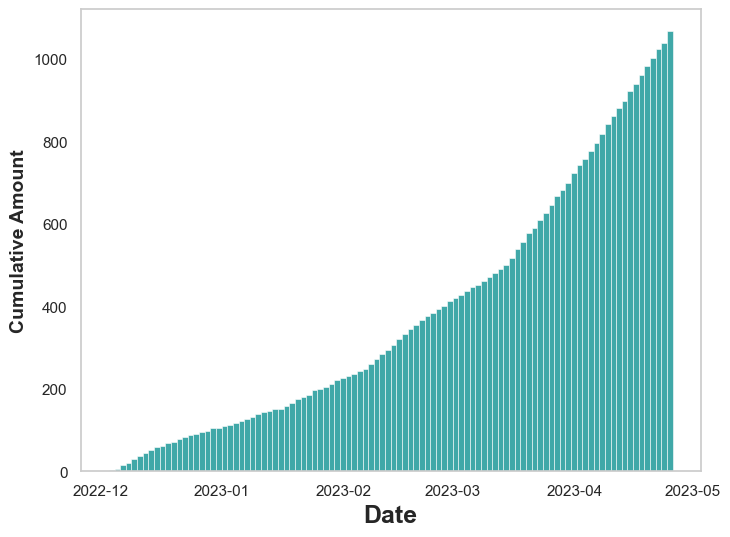

In [31]:
#Plotting the cumulative amount of posts over time

#Converting "Date & Time" column to datetime format
df_post["Date & Time"] = pd.to_datetime(df_post["Date & Time"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
#Dropping rows with missing values (just in case)
df_post.dropna(subset=["Date & Time"], inplace=True)

#Creating a plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_post, x='Date & Time', bins=100, kde=False, ax=ax, color="darkcyan", cumulative=True)

ax.set_ylabel('Cumulative Amount', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=18, fontweight='bold')

plt.grid()
plt.show()

In [32]:
#Getting the top five most popular posts

#Getting the top five most popular posts
top_posts = df_post.sort_values("Score", ascending=False).head(5)

#Printing the top five most popular posts
print("Top 5 most popular posts:")
for i, post in top_posts.iterrows():
    print(f"{i + 1}. {post['Title Post']} (Score: {post['Score']}, Comments: {post['Number of Comments']})")

Top 5 most popular posts:
958. Imagine someone failing their class because of this reliable ChatGPT detector... (Score: 50350, Comments: 1290)
947. The newest version of ChatGPT passed the US medical licensing exam with flying colors — and diagnosed a 1 in 100,000 condition in seconds (Score: 45093, Comments: 2932)
949. Well that escalated quickly ChatGPT (Score: 35960, Comments: 625)
1. Was curious if GPT-4 could recognize text art (Score: 35791, Comments: 619)
963. ChatGPT passes MBA exam given by a Wharton professor. (Score: 33066, Comments: 2178)


# 4. Topic modelling
Results in this notebook may vary slightly than mentioned in the paper. It is not possible to replicate the results from the BERTopic model 100% each run.

In [2]:
#Import the data
df_post = pd.read_csv(cwd+ '/data/Post_dataset_processed.csv')

## 4.1 Performing the topic modelling

In [3]:
#The data should already be processed based on the "Processing" notebook
#This preprocessing step is specifically for BERTopic
def BERTopic_preprocessing(df_file:pd.DataFrame, columns:list[str]):
    '''
    Assign the df to df_file
    Assign the columns you want to keep to columns
    Combines all columns per row into a single string
    Output: The df ready for BERTopic modelling to data:list[str]
    '''
    #Creating strings per row, for each column
    df_file['combined']:str = ""
    for col in columns:
        df_file['combined'] += df_file[col].astype(str) + " "
    df_file['combined'] = df_file['combined'].str.strip() #removing trailing spaces
    #Combining all strings into a list
    data = df_file['combined'].tolist()
    
    return data

#Applying the topic modelling to the data
def BERTopic_modelling(model_data:list[str]):
    '''
    Assign the data to model_data
    Fits the data to the BERTopic model
    Outputs the topics and probabilities
    Visualizes the topics based on total amount, frequency & intertopic distance map
    '''
    vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english") #Performing extra removal of stopwords
    umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=9) #To make it reproducible
    model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model)
    topics, probabilities = model.fit_transform(model_data)
    print(f'Total amount of topics: {len(model.get_topics().keys())}\n')
    print(f'Insight into the first five topics: \n {model.get_topic_freq().head()}')
    return model, probabilities

In [4]:
TRAINED = True #Assign true if you want to load the model, false if you want to train the model

#Preprocessing the data
data = BERTopic_preprocessing(df_file = df_post, columns = [
                                                    'Title Post', 'Post Text', 'Text of URL Post'
                                                    ])

if TRAINED:
    model = BERTopic.load(cwd+ "/models/TopicModel") #loading the model
else:
    #Applying BERTopic to the data
    model, probabilities = BERTopic_modelling(model_data = data)
    model.save(cwd+ "/models/TopicModel") #saving the model

Total amount of topics: 23

Insight into the first five topics: 
    Topic  Count
0     -1    439
1      0     87
2      1     48
3      2     43
4      3     43


In [5]:
#Getting the frequency of posts in topics
model.get_topic_freq()

,Topic,Count
0,-1,439
1,0,87
2,1,48
3,2,43
4,3,43
5,4,42
6,5,34
7,6,34
8,7,33
9,8,29


## 4.2 Visualizing the results from topic modelling

In [6]:
#Defining function to visualize the topics with frequent words and posts
def BERTopic_visualization(model, model_data:list[str]):
    '''
    Assign the model to model
    Assign the theprecessed data to model_data
    Visualizes the topics based on total amount, frequency & intertopic distance map
    '''
    #Creating a dataframe with the topics and their top words
    df_topic_word = pd.DataFrame(columns = ['Topic Number', 'Top Words', 'Weight'])
    df_topic_doc = pd.DataFrame(columns = ['Topic Number', 'Representative Docs'])
    for topic in model.get_topics().keys():
        topic_data = model.get_topic(topic)
        for index in range(len(topic_data)):
            df_topic_word = df_topic_word.append({'Topic Number': topic, 'Top Words': topic_data[index][0], 'Weight': topic_data[index][1]}, ignore_index=True)
    #Creating a dataframe with the topics and their representative documents    
        topic_docs = model.get_representative_docs(topic)
        for doc in topic_docs:
            df_topic_doc  = df_topic_doc.append({'Topic Number': topic, 'Representative Docs': doc}, ignore_index=True)
    return df_topic_word, df_topic_doc

In [7]:
#Calling the visualization and saving the results
df_topic_word1, df_topic_doc1 = BERTopic_visualization(model = model, model_data = data)

df_topic_word1.to_csv(cwd+ "/data/Topic_repr_words.csv")
df_topic_doc1.to_csv(cwd+ "/data/Topic_repr_docs.csv")

#Saving the results to combine them with the actual posts
document_info = model.get_document_info(docs=df_post['Title Post'])
document_info = document_info.rename(columns={'Document': 'Title Post'})
document_info.to_csv(cwd+ "/data/df_post_topic.csv")

In [8]:
#Visualzing the most common words per topic, for the first 10 topics
print('Barchart of most common words per topic')
model.visualize_barchart(n_words=10, top_n_topics=10, width=300, height=300)

Barchart of most common words per topic


In [9]:
#Plotting the similarity between topics through a heatmap
print('Heatmap based on similarity')
model.visualize_heatmap(n_clusters=10)

Heatmap based on similarity


In [10]:
#Plotting the differences and similarities between topics on two axis
print('Map of topics')
model.visualize_documents(data, reduced_embeddings=None, height=600)

Map of topics


In [12]:
#Visualziing the intertopic distance between topics
print('Intertopic Distance Map')
model.visualize_topics()

Intertopic Distance Map


# 5. Sentiment analysis

In [41]:
#Import the dataframes we've created
df_comment = pd.read_csv(cwd+"/data/Comment_dataset_processed.csv")
df_submission = pd.read_csv(cwd+"/data/Post_dataset_processed.csv")

In [14]:
#Import the tokenized and model
tokenizer = AutoTokenizer.from_pretrained("Seethal/sentiment_analysis_generic_dataset")
model = TFAutoModelForSequenceClassification.from_pretrained("Seethal/sentiment_analysis_generic_dataset", from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## 5.1 Preprocessing for sentiment analysis
The maximum length per comment that the model can handle is 512. However, based on the distribution of the length of the comments only 8.59% would be too long to analyze.
To optimize the performance of the model, the comments with more than 512 tokens will be removed.

Percentage of rows that exceed a length of 512 tokens: 8.59%


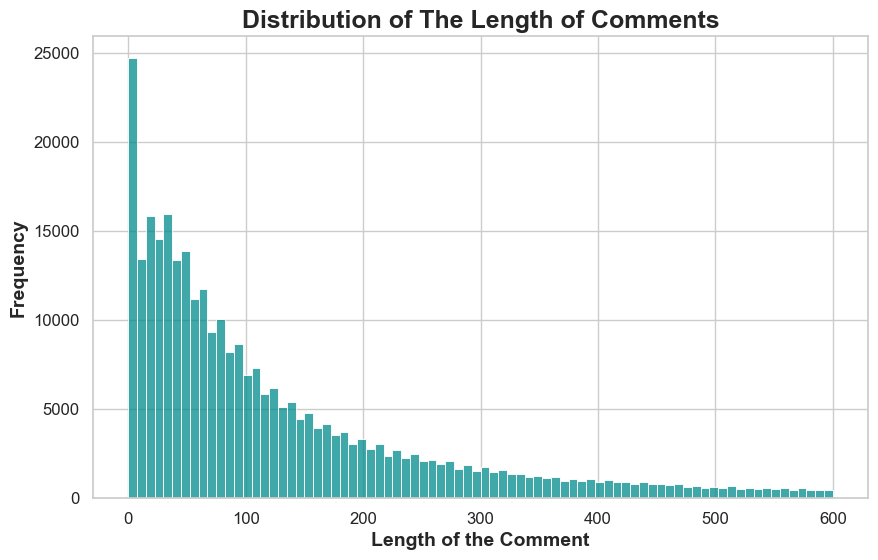

In [15]:
#Printing the percentage of rows that exceed a length of 130
print(f"Percentage of rows that exceed a length of 512 tokens: {((len(df_comment[df_comment['Comment Text'].str.len() > 512])/len(df_comment)) * 100):.2f}%")

#Plotting the histogram of the distribution of the length of the comments
plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment['Comment Text'].str.len(), bins=80, kde=False, binrange=[0, 600], color="darkcyan")

plt.xlabel('Length of the Comment', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of The Length of Comments' , fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

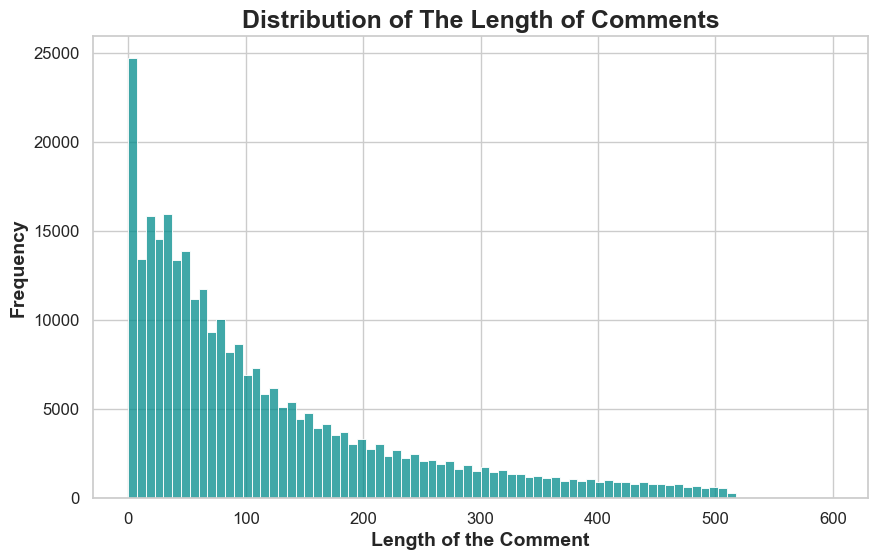

In [16]:
#removing rows with "Comment Text" Length > 512
df_comment = df_comment[df_comment['Comment Text'].str.len() <= 512]

#Plotting the histogram of the remaining comments
plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment['Comment Text'].str.len(), bins=80, kde=False, binrange=[0, 600], color="darkcyan")

plt.xlabel('Length of the Comment', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of The Length of Comments' , fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 5.2 Getting the sentiment score
This scaling operation maps the range of 'x' from its original range to a new range between 0 and 1. For example, when the original value of 'x' is -4, the scaled value would be 0, and if the original value of 'x' is 4, the scaled value would be 1.

In [17]:
#To explain how the sentiment works, we will use the following sentence:
length = 20000
sentence = "a" * length

#Using the tokenizer to encode the sentence and return the input as tensor
inputs = tokenizer(sentence, return_tensors="tf")
logits = model(**inputs).logits

#Getting the sentimnet
scale = lambda x: (x+4) / 8
print(f"Logits unedited: {logits[0]}")
print(f"Logits scaled 0-1: {scale(logits[0])}")
logits = [scale(logits[0])[0], scale(logits[0])[2]]
print(f"Logits softmax: {logits}") #Softmax normalizes the logits to a probability distribution
print(f"negative: {logits[0]}")
print(f"Positive: {logits[1]}")
print(f"Sentiment Score: {logits[1] - logits[0]}")

Logits unedited: [-0.7556559   0.555634    0.02431944]
Logits scaled 0-1: [0.40554303 0.56945425 0.50303996]
Logits softmax: [<tf.Tensor: shape=(), dtype=float32, numpy=0.40554303>, <tf.Tensor: shape=(), dtype=float32, numpy=0.50303996>]
negative: 0.4055430293083191
Positive: 0.5030399560928345
Sentiment Score: 0.09749692678451538


In [34]:
#Getting the sentiment score for the comments
def sentiment_score(df_file: pd.DataFrame, column_name: str, batch_size: int):
    """
    Assign a preprocessed dataframe to df_file
    Assign a single column name to column_name for the text to be used for sentiment analysis
    Assign a batch size to batch_size for processing in batches (in accordence with GPU capabilities)
    Tokenizes the text and returns the sentiment score and label for each text
    Returns the dataframe with the new columns; Sentiment, Negative, Neutral & Positive.
    """
    scale = lambda x: (x+4) / 8
    negative = np.array([])
    neutral = np.array([])
    positive = np.array([])
    n = len(df_file)
    num_batches = n // batch_size + int(n % batch_size != 0)
    for i in tqdm.tqdm(range(num_batches), total=num_batches):
        start = i * batch_size
        end = min(start + batch_size, n)
        batch = df_file.iloc[start:end][column_name].values.tolist()
        try:
            tokens = tokenizer(batch, return_tensors="tf", padding=True, truncation=True)
        except:
            print("Error at", i, "around index", i * batch_size)

        inputs = {key: tuple(value.numpy().tolist()) for key, value in tokens.items()} 
        inputs = inputs["input_ids"]
        with tf.device('/gpu:0'): #in order to make use of the GPU
            predictions = model.predict(inputs, verbose=False)["logits"]
        negative = np.concatenate((negative, scale(predictions)[:,0]))
        neutral = np.concatenate((neutral, scale(predictions)[:,1]))
        positive =  np.concatenate((positive, scale(predictions)[:,2]))

    #Calculating the sentiment score
    sentiment = positive - negative
    #Adding the columns        
    df_file["Sentiment"] = sentiment
    df_file["Negative"] = negative
    df_file["Neutral"] = neutral
    df_file["Positive"] = positive
    return df_file

In [42]:
#Calling the function
df_comment.dropna(subset=['Comment Text'], inplace=True) #Keeping only what we need for the sentiment analysis
df_sentiment_score = sentiment_score(df_file=df_comment, column_name="Comment Text", batch_size=32)
df_sentiment_score.to_csv(cwd+"/data/Comment_sentiment_score.csv", index=False)

100%|██████████| 9624/9624 [1:20:17<00:00,  2.00it/s]


## 5.3 Validating the model's results

In [45]:
#Taking a random sample of 100 comments
random_sample = df_sentiment_score.sample(n=100, random_state=9)

#Only keeping the columns we need
random_sample = random_sample[['Comment Text', 'Sentiment']]

#Saving the sample
random_sample.to_csv(cwd+"/data/Random_sample.csv", index=False)

In [58]:
#The following dataset was made outside of this notebook, by three scholars assigning a sentiment score to a 100 comments
df_manual_sentiment = pd.read_csv(cwd+"/data/Manual_sentiment_analysis.csv")

df_manual_sentiment.rename(columns={'1':'Manual Sentiment 1', '2':'Manual Sentiment 2', 'comapre':'Manual Coding Evaluation', 'final':'Manual Sentiment 3'}, inplace=True)
df_manual_sentiment.head()

,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment
0,I have played with thisâ€”my latest attempts i...,0,0,True,NaN,-0.031120
1,Jaja Elon Musk is a retard,-,-,True,NaN,0.013528
2,"Then, what is its difference with a simple AI ...",0,0,True,NaN,0.034319
3,I just find it fascinating that we're witnessi...,+,+,True,NaN,0.054592
4,I built a tool that sniffs out students who us...,0,0,True,NaN,0.064011


In [59]:
#Adding a column based on the final manually coded sentiment
df_manual_sentiment['Final Manual'] = 0
for index1, row1 in enumerate(df_manual_sentiment['Manual Coding Evaluation']):
    if row1 == True:
        df_manual_sentiment['Final Manual'][index1] = df_manual_sentiment['Manual Sentiment 1'][index1]
    else:
        df_manual_sentiment['Final Manual'][index1] = df_manual_sentiment['Manual Sentiment 3'][index1] 

df_manual_sentiment.head()

,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment,Final Manual
0,I have played with thisâ€”my latest attempts i...,0,0,True,NaN,-0.031120,0
1,Jaja Elon Musk is a retard,-,-,True,NaN,0.013528,-
2,"Then, what is its difference with a simple AI ...",0,0,True,NaN,0.034319,0
3,I just find it fascinating that we're witnessi...,+,+,True,NaN,0.054592,+
4,I built a tool that sniffs out students who us...,0,0,True,NaN,0.064011,0


In [60]:
#Adding a column to label the sentiment score given by the model
df_manual_sentiment['Final Model'] = 0
for index2, row2 in enumerate(df_manual_sentiment['Sentiment']):
    if row2 < -0.25:
        df_manual_sentiment['Final Model'][index2] = '-'
    elif row2 > 0.25:
        df_manual_sentiment['Final Model'][index2] = '+'
    else:
        df_manual_sentiment['Final Model'][index2] = '0'

df_manual_sentiment.head()

,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment,Final Manual,Final Model
0,I have played with thisâ€”my latest attempts i...,0,0,True,NaN,-0.031120,0,0
1,Jaja Elon Musk is a retard,-,-,True,NaN,0.013528,-,0
2,"Then, what is its difference with a simple AI ...",0,0,True,NaN,0.034319,0,0
3,I just find it fascinating that we're witnessi...,+,+,True,NaN,0.054592,+,0
4,I built a tool that sniffs out students who us...,0,0,True,NaN,0.064011,0,0


In [92]:
#Calculating the accuracy of the model
df_manual_sentiment['Correct'] = 0
for index3, row3 in enumerate(df_manual_sentiment['Final Manual']):
    if row3 == df_manual_sentiment['Final Model'][index3]:
        df_manual_sentiment['Correct'][index3] = 1
    else:
        df_manual_sentiment['Correct'][index3] = 0


In [97]:
#Printing the agreement between coders
print(f"The agreement between the coders is: {df_manual_sentiment['Manual Coding Evaluation'].sum()/len(df_manual_sentiment)*100}%")

#The accuracy
print(f"The accuracy of the model is: {df_manual_sentiment['Correct'].sum()/len(df_manual_sentiment)*100}%")


The agreement between the coders is: 65.0%
The accuracy of the model is: 64.0%


In [96]:
#Converting string labels to numerical labels
le = LabelEncoder()
sentiment_manual = le.fit_transform(df_manual_sentiment['Final Manual'])
sentiment_model= le.transform(df_manual_sentiment['Final Model'])

# Calculate precision, recall, and F1-score
report = classification_report(sentiment_manual, sentiment_model, target_names=le.classes_)

print(report)


              precision    recall  f1-score   support

           +       0.50      0.24      0.32        17
           -       0.67      0.25      0.36        24
           0       0.65      0.92      0.76        59

    accuracy                           0.64       100
   macro avg       0.61      0.47      0.48       100
weighted avg       0.63      0.64      0.59       100



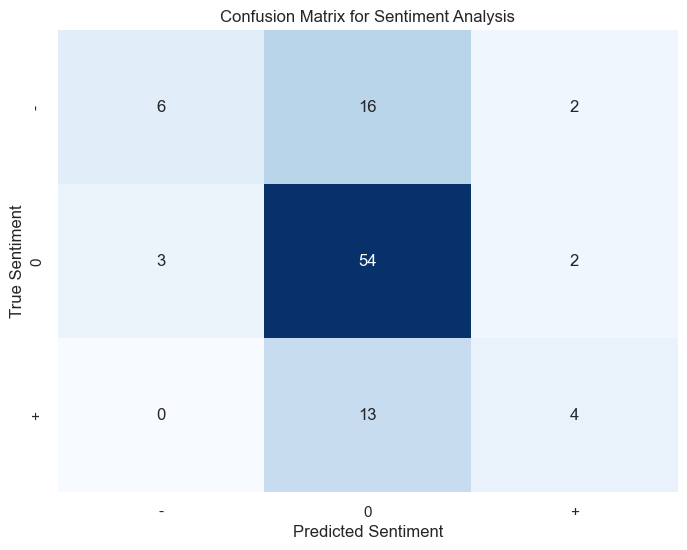

In [65]:
#Plotting confusion matrix
labels =['-', '0', '+']
cm = confusion_matrix(df_manual_sentiment['Final Manual'], df_manual_sentiment['Final Model'], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for Sentiment Analysis')

plt.show()

## 5.4 Exploring the sentiment results

In [66]:
#What the dataframe looks like
df_sentiment_score.head()

,Subreddit,ID of Post,Comment Text,Score,Author,Date & Time,Sentiment,Negative,Neutral,Positive
0,technology,12ewvo1,Not to nitpick… BUT the rarity of a condition ...,10128,Little_Duckling,2023-04-07 22:28:34,0.025831,0.282611,0.859331,0.308443
1,technology,12ewvo1,Can't wait for the future where doctor bot can...,21902,apistat,2023-04-07 22:02:45,0.097016,0.278627,0.815911,0.375643
2,technology,12ewvo1,I don’t think anyone ever doubted a computer c...,2762,oskie6,2023-04-07 22:50:21,0.109268,0.272137,0.805490,0.381404
3,technology,12ewvo1,Reminds me of when IBM rolled out Watson. I w...,4024,FreezingRobot,2023-04-07 22:08:05,-0.631202,0.791989,0.486519,0.160787
4,technology,12ewvo1,Feel free to hate me for saying this but I fee...,1445,Informal_Internal977,2023-04-07 22:48:22,-0.036095,0.310594,0.866030,0.274499


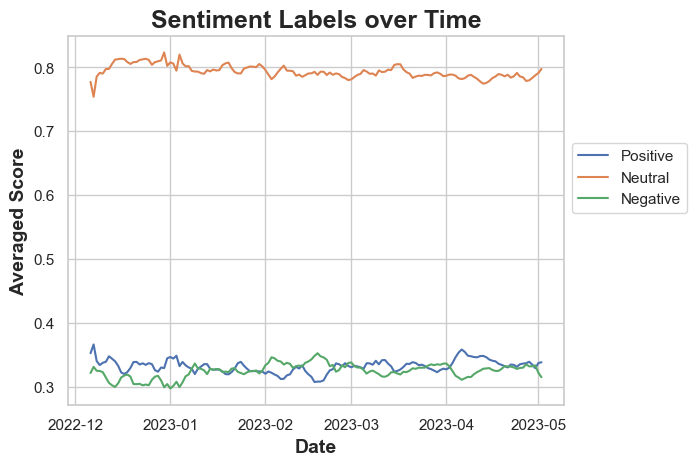

In [67]:
#Plotting the distribution of the sentiment labels over time

#Sorting the dataframe by date
df_sentiment_score.sort_values(by=["Date & Time"], inplace=True)
#Adding a column that extracts the date from the datetime column:
df_sentiment_score['Date'] = pd.to_datetime(df_sentiment_score['Date & Time']).dt.date

#Creating a new dataset with 4 columns, every row is a unique day, and the columns are the average sentiment score, negative, neutral and positive:
df_sentiment_score_daily = df_sentiment_score.groupby(['Date']).mean().reset_index()
#df_sentiment_score_daily["scaled_sentiment"] is the sentiment score for each day, scaled between 0 and 1 based on the positive and negative sentiment scores for the entire period, excluding the neutral sentiment score
df_sentiment_score_daily["scaled_sentiment"] = (df_sentiment_score_daily["Sentiment"] - df_sentiment_score_daily["Sentiment"].min()) / (df_sentiment_score_daily["Sentiment"].max() - df_sentiment_score_daily["Sentiment"].min())

#Plotting the sentiment labels over time
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Positive'].rolling(window=4).mean(), label='Positive')
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Neutral'].rolling(window=4).mean(), label='Neutral')
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Negative'].rolling(window=4).mean(), label='Negative')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Averaged Score', fontsize=14, fontweight='bold')
plt.title('Sentiment Labels over Time' , fontsize=18, fontweight='bold')

plt.show()

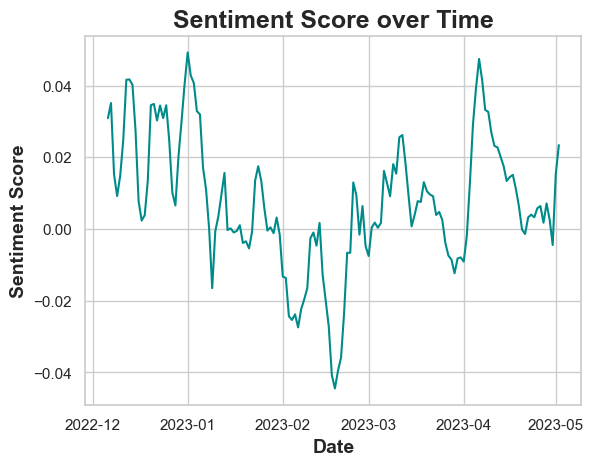

In [68]:
#Plotting the sentiment score over time
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Sentiment'].rolling(window=4).mean(), label='Sentiment Score', color="darkcyan")


plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.title('Sentiment Score over Time' , fontsize=18, fontweight='bold')

plt.show()

In [69]:
#Statistics on the sentiment score
print(f"Some information about the sentiment score:\n{df_sentiment_score['Sentiment'].describe()}\n")

Some information about the sentiment score:
count    307950.000000
mean          0.006317
std           0.267838
min          -0.881379
25%          -0.029733
50%           0.022274
75%           0.059453
max           1.008014
Name: Sentiment, dtype: float64



In [70]:
#looking at the comment text with the highest and lowest sentiment score
print(df_sentiment_score[df_sentiment_score['Sentiment'] == df_sentiment_score['Sentiment'].max()]['Comment Text'])
#As someone who has been following the development of natural language processing (NLP) technologies for years, I must say that I am absolutely thrilled by the emergence of  .
#For those who are not familiar with it,   is a cutting-edge NLP technology that allows users to engage in natural, conversational exchanges with a machine-learning model.
#What sets   apart from other NLP technologies is its ability to generate responses that are not only accurate and coherent, but also engaging and compelling. In other words, it can not only understand what you are saying,
#but it can also respond in a way that is relevant, thoughtful, and even witty. This level of interaction is something that we have never seen before in the world of NLP, 
#and it represents a major step forward in our ability to create truly intelligent machines.
#But the potential applications of   are not limited to mere conversation. With its ability to understand and respond to complex inputs,   has the potential to revolutionize the way we interact with computers in a wide range of contexts. For example,
#it could be used to create virtual assistants that are capable of providing personalized, intelligent support to users in real-time. It could also be used to power advanced chatbots that can help users navigate complex systems and processes,
#or even provide personalized recommendations based on their interests and preferences.
#In short,   represents a major leap forward in the field of NLP, and I am incredibly excited to see how it will be used in the coming years. It has the potential to revolutionize the way we interact with computers,
#and I can't wait to see what the future holds for this incredible technology.
#[this was made in  , but pretty much sums it up]

print(df_sentiment_score[df_sentiment_score['Sentiment'] == df_sentiment_score['Sentiment'].min()]['Comment Text'])
#Why do I fucking feel 20 years from now in a post-apocalyptic landscape somewhere I am going to run into one of these surviving AI ethics team members in a cave who explains to me "We tried to warn them,
#but they just wouldn't listen." when I ask him on how the world was destroyed and the bots took over.

221030    As someone who has been following the developm...
Name: Comment Text, dtype: object
120753    Why do I fucking feel 20 years from now in a p...
Name: Comment Text, dtype: object


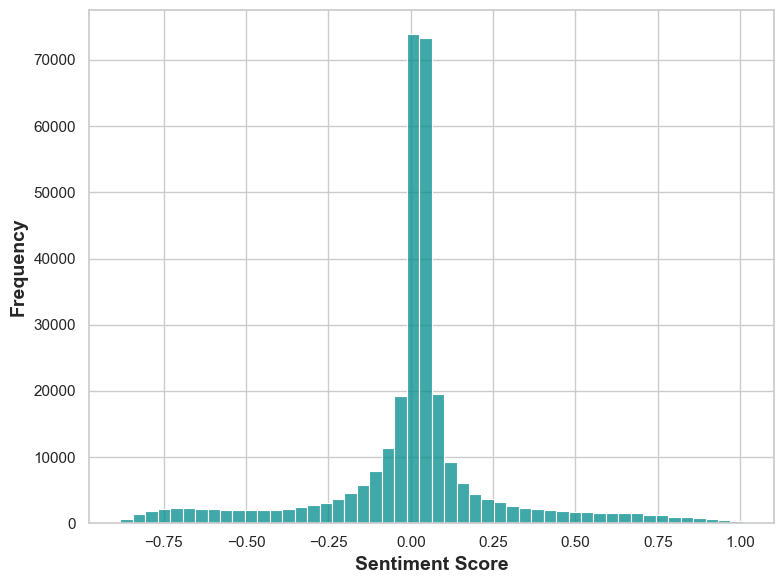

In [87]:
#Plotting the distribution of the sentiment score
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_sentiment_score, x='Sentiment', bins=50, kde=False, ax=ax, color="darkcyan")

plt.xlabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

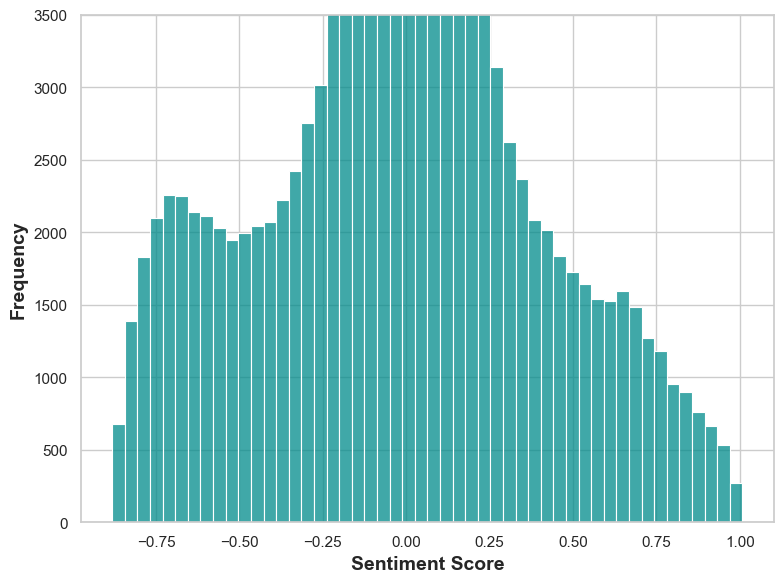

In [89]:
#Zooming the plot in to get more detailed information
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_sentiment_score, x='Sentiment', bins=50, kde=False, ax=ax, color="darkcyan")

ax.set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_ylim(0, 3500) #to zoom in


plt.tight_layout()
plt.show()

In [73]:
#Percentage of neutral comments: sentiment score between -0.25 and 0.25
print(f"The percentage of comments with a sentiment score between -0.25 and 0.25 is: {round(len(df_sentiment_score[(df_sentiment_score['Sentiment'] >= -0.25) & (df_sentiment_score['Sentiment'] <= 0.25)])/len(df_sentiment_score)*100, 2)}%\n")
#Percentage of negative comments: sentiment score smaller than -0.25
print(f"The percentage of comments with a sentiment score smaller than -0.25 is: {round(len(df_sentiment_score[df_sentiment_score['Sentiment'] < -0.25])/len(df_sentiment_score)*100, 2)}%\n")
#Percentage of positive comments: sentiment score larger than 0.25
print(f"The percentage of comments with a sentiment score larger than 0.25 is: {round(len(df_sentiment_score[df_sentiment_score['Sentiment'] > 0.25])/len(df_sentiment_score)*100, 2)}%\n")

#Removing rows with a sentiment score between -0.25 and 0.25
df_sentiment_nonneutral = df_sentiment_score[(df_sentiment_score['Sentiment'] < -0.25) | (df_sentiment_score['Sentiment'] > 0.25)]
#Percantage of sentiment smaller than -0.5
print(f"The percentage of comments with a sentiment score smaller than -0.5 is (after removing neutral comments): {round(len(df_sentiment_nonneutral[df_sentiment_nonneutral['Sentiment'] < -0.5])/len(df_sentiment_nonneutral)*100, 2)}%\n")
#Percentage of sentiment larger than 0.5
print(f"The percentage of comments with a sentiment score larger than 0.5 is(after removing neutral comments): {round(len(df_sentiment_nonneutral[df_sentiment_nonneutral['Sentiment'] > 0.5])/len(df_sentiment_nonneutral)*100, 2)}%")

The percentage of comments with a sentiment score between -0.25 and 0.25 is: 79.02%

The percentage of comments with a sentiment score smaller than -0.25 is: 11.14%

The percentage of comments with a sentiment score larger than 0.25 is: 9.84%

The percentage of comments with a sentiment score smaller than -0.5 is (after removing neutral comments): 29.27%

The percentage of comments with a sentiment score larger than 0.5 is(after removing neutral comments): 23.37%


# 6. Combining the results from topic modelling and sentiment analysis

In [74]:
df_post_topic = pd.read_csv(cwd+"/data/df_post_topic.csv")

## 6.1 Creating and interpreting with sentiment score average

In [75]:
#Only keeping what we want
df_post_topic.drop(['Unnamed: 0', 'Top_n_words', 'Probability', 'Representative_document', 'Title Post'], axis=1, inplace=True)

df_post_topic['Sentiment'] = 0
df_post_topic.update(df_sentiment_score)

#Grouping the sentiment score by topic
df_topic_sentiment_score = df_post_topic.groupby('Name')[['Sentiment', 'Topic']].mean().reset_index()

#Ordering based on the Topic Number
df_topic_sentiment_score.sort_values(by=['Topic'], inplace=True)
df_topic_sentiment_score.reset_index(drop=True, inplace=True)

#Changing the Topic Number to integer
df_topic_sentiment_score["Topic"] = df_topic_sentiment_score["Topic"].astype(int)

#Dropping the Topic -1 row from the dataset (since this is not a topic)
df_topic_sentiment_score.drop(df_topic_sentiment_score[df_topic_sentiment_score['Topic'] == -1].index, inplace=True)

df_topic_sentiment_score.head()

,Name,Sentiment,Topic
1,0_chatgpt_app_api_install,-0.036742,0
2,1_dont_bing_im_disclaimer,-0.011571,1
3,2_art_image_design_ascii,-0.044640,2
4,3_ai_said_link_jobs,-0.058816,3
5,4_thank_polite_love_posted,-0.009941,4


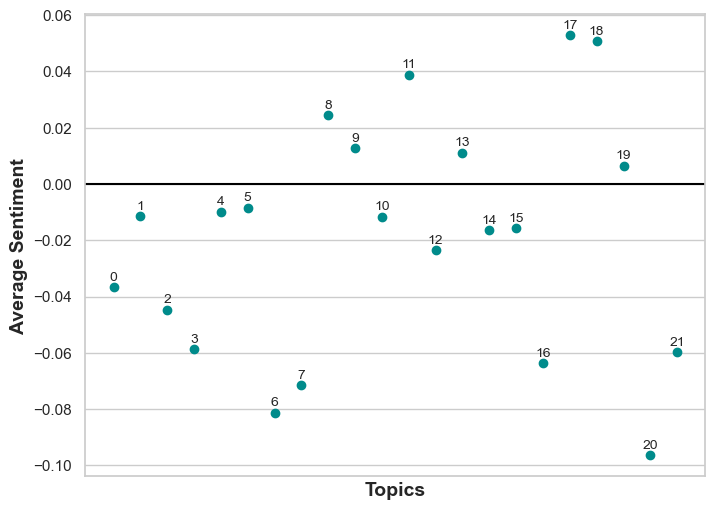

In [76]:
#Plotting the sentiment score per topic
fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(data=df_topic_sentiment_score, x='Topic',y='Sentiment',  color="darkcyan")

#Adding value for 'Topic Number' next to each dot
for i in range(len(df_topic_sentiment_score)):
    ax.annotate(df_topic_sentiment_score['Topic'].iloc[i],
                (df_topic_sentiment_score['Topic'].iloc[i], df_topic_sentiment_score['Sentiment'].iloc[i]),
                textcoords="offset points",
                xytext=(0, 5),
                ha='center',
                fontsize=10)

plt.xlabel('Topics', fontsize=14, fontweight='bold')
plt.ylabel('Average Sentiment', fontsize=14, fontweight='bold')


plt.xticks([])
ax.axhline(0, color='black', linewidth=1.5)

plt.show()

In [77]:
#Calculating the one way anova for each topic
result = []
for i in range(len(df_topic_sentiment_score)):
    result.append(f_oneway(df_post_topic[df_post_topic['Topic'] == df_topic_sentiment_score['Topic'].iloc[i]]['Sentiment'],
                           df_post_topic[df_post_topic['Topic'] != df_topic_sentiment_score['Topic'].iloc[i]]['Sentiment']))

#Creating a dataframe with the results
df_anova = pd.DataFrame(result, columns=['Statistic', 'p-value'])

#Adding the topic number to the dataframe
df_anova['Topic'] = df_topic_sentiment_score['Topic']


df_anova

,Statistic,p-value,Topic
0,0.742096,0.389184,NaN
1,0.005927,0.938649,0.0
2,0.641830,0.423227,1.0
3,1.383372,0.239790,2.0
4,0.013078,0.908973,3.0
5,0.018929,0.890597,4.0
6,2.461707,0.116949,5.0
7,1.733792,0.188211,6.0
8,0.696040,0.404305,7.0
9,0.336470,0.561997,8.0


## 6.2 Creating and interpreting with sentiment label

In [78]:
#Creating a dataset with all the sentiment values per topic
df_topic_sentimentscore = df_post_topic

#Adding new columns to the df_post_topic dataset
df_topic_sentimentscore['ID of Post'] = 0
#Filling the new column
df_topic_sentimentscore.update(df_post)

df_topic_sentimentscore.head()

,Topic,Name,Sentiment,ID of Post
0,2,2_art_image_design_ascii,0.025831,12cobqr
1,19,19_fucking_offensive_robot_shit,0.097016,12ed85v
2,4,4_thank_polite_love_posted,0.109268,12b7bos
3,0,0_chatgpt_app_api_install,-0.631202,zj2aeu
4,-1,-1_ai_like_link_chatgpt,-0.036095,11yau45


In [79]:
df_sentiment_label = df_sentiment_score

df_sentiment_label['Label'] = 0
for i, r in enumerate(df_sentiment_label['Sentiment']):
    if r <= -0.5:
        df_sentiment_label['Label'][i] = 'Strong Negative'
    elif r < -0.25:
        df_sentiment_label['Label'][i] = 'Negative'
    elif r >= 0.5:
        df_sentiment_label['Label'][i] = 'Strong Positive'
    elif r > 0.25:
        df_sentiment_label['Label'][i] = 'Positive'
    else:
        df_sentiment_label['Label'][i] = 'Neutral'

df_sentiment_label.head()

,Subreddit,ID of Post,Comment Text,Score,Author,Date & Time,Sentiment,Negative,Neutral,Positive,Date,Label
291460,ChatGPT,zb7cb9,did not work for me,1,CheesyWalnut,2022-12-03 06:49:14,0.041696,0.222792,0.964542,0.264488,2022-12-03,Neutral
291468,ChatGPT,zb7cb9,Did you refresh the page before trying to get ...,2,grumble-pig,2022-12-03 06:52:19,-0.002089,0.271479,0.908159,0.269389,2022-12-03,Neutral
291475,ChatGPT,zb7cb9,Wow I got it to work thanks had to reload a fe...,1,CheesyWalnut,2022-12-03 07:28:37,0.071136,0.222554,0.938993,0.293690,2022-12-03,Positive
291469,ChatGPT,zb7cb9,Works for me (disclaimer: I do not endorse thi...,3,grumble-pig,2022-12-03 09:44:26,0.291360,0.152120,0.886280,0.443480,2022-12-03,Neutral
291453,ChatGPT,zb7cb9,"[Oh no]( enjoy it while it lasts, I am sure t...",31,Jeffy29,2022-12-03 09:48:08,-0.483653,0.631624,0.641227,0.147971,2022-12-03,Neutral


In [80]:
#Creating new df with amount of labels per ID of Post
df_sentiment_label_count = df_sentiment_label.groupby('ID of Post')['Label'].value_counts().unstack().fillna(0).astype(int).reset_index()
#Adding column with total amount of labels per ID of Post
df_sentiment_label_count['Total'] = df_sentiment_label_count['Negative'] + df_sentiment_label_count['Positive'] + df_sentiment_label_count['Neutral'] + df_sentiment_label_count['Strong Negative'] + df_sentiment_label_count['Strong Positive']

df_sentiment_label_count.head()

Label,ID of Post,0,Negative,Neutral,Positive,Strong Negative,Strong Positive,Total
0,100a5qq,0,0,31,1,4,2,38
1,100pepu,0,11,97,3,14,8,133
2,100s6bm,0,2,26,1,2,1,32
3,100xbh3,0,16,264,16,11,12,319
4,101e454,0,14,232,18,18,13,295


In [81]:
#Creating new columns with the labels
df_topic_sentimentscore['Strong Negative'] = 0
df_topic_sentimentscore['Negative'] = 0
df_topic_sentimentscore['Neutral'] = 0
df_topic_sentimentscore['Positive'] = 0
df_topic_sentimentscore['Strong Positive'] = 0

df_topic_sentimentscore['Total'] = 0

df_topic_sentimentscore.update(df_sentiment_label_count)

#Grouping by topic
df_topic_sentimentscore = df_topic_sentimentscore.groupby('Topic').sum().reset_index()

df_topic_sentimentscore.head()

,Topic,Sentiment,Strong Negative,Negative,Neutral,Positive,Strong Positive,Total
0,-1,-0.726659,7728,6216,98835,6197,6186,125162
1,0,-3.196553,1394,1192,18806,1124,1119,23635
2,1,-0.555425,873,730,11561,772,746,14682
3,2,-1.919500,758,624,9445,590,613,12030
4,3,-2.529075,706,562,9011,576,518,11373


In [82]:
#Dropping the Topic -1 row from the dataset
df_topic_sentimentscore.drop(df_topic_sentimentscore[df_topic_sentimentscore['Topic'] == -1].index, inplace=True)

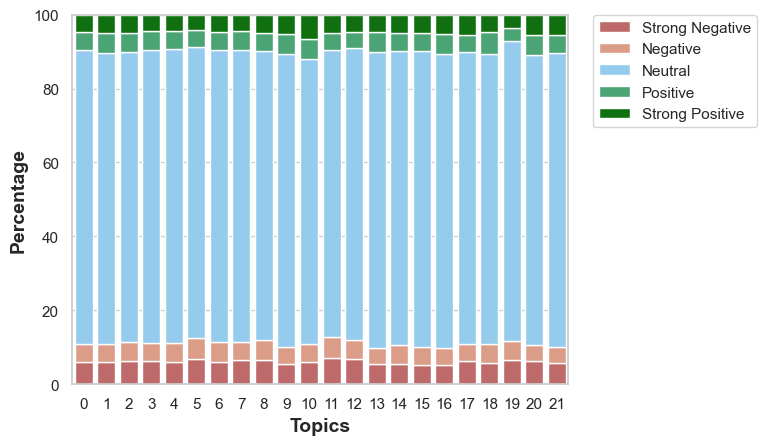

In [83]:
#Plotting the portion of each sentiment per topic
sentiment_columns = ['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive']

df = df_topic_sentimentscore

for col in sentiment_columns:
    df[col + ' (%)'] = (df[col] / df['Total']) * 100

#Creating the figure and axes
fig, ax = plt.subplots()

#Plotting the stacked bar chart using Seaborn style
sns.barplot(x='Topic', y='Strong Negative (%)', data=df, color='indianred', label='Strong Negative')
sns.barplot(x='Topic', y='Negative (%)', data=df, color='darksalmon', label='Negative',
            bottom=df['Strong Negative (%)'])
sns.barplot(x='Topic', y='Neutral (%)', data=df, color='lightskyblue', label='Neutral',
            bottom=df['Strong Negative (%)'] + df['Negative (%)'])
sns.barplot(x='Topic', y='Positive (%)', data=df, color='mediumseagreen', label='Positive',
            bottom=df['Strong Negative (%)'] + df['Negative (%)'] + df['Neutral (%)'])
sns.barplot(x='Topic', y='Strong Positive (%)', data=df, color='green', label='Strong Positive',
            bottom=df['Strong Negative (%)'] + df['Negative (%)'] + df['Neutral (%)'] + df['Positive (%)'])

ax.set_xlabel('Topics', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=14, fontweight='bold')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_ylim(0, 100)

plt.show()